In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
#import warnings
#warning.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score,f1_score
from collections import Counter

# This section focuses on Cleaning the RedLight Camera Dataframe

In [2]:
#Load Redlight camera data from database extracts
df_RL=pd.read_csv("../DB_Extracts/red_light_camera.csv")
df_RL.head(5)

,id,INTERSECTION_ID,LINEAR_NAME_FULL_1,LINEAR_NAME_FULL_2,ID1,X,Y,LONGITUDE,LATITUDE,OBJECTID,...,ADDITIONAL_INFO,POLICE_DIVISION_1,WARD_1,WARD_3,WARD_2,WARD_4,NAME,DISTRICT,RLC,MAIN
0,1843,13465959.0,Richmond St E,Parliament St,1,NaN,NaN,NaN,NaN,1,...,NaN,51,Toronto Centre(13),NaN,NaN,NaN,Richmond St E And Parliament St,Toronto and East York,6001,RICHMOND ST E
1,1844,13467993.0,Lake Shore Blvd W,York St,2,NaN,NaN,NaN,NaN,2,...,WB LAKE SHORE BLVD,52,Spadina-Fort York(10),NaN,NaN,NaN,Lake Shore Blvd W And York St,Toronto and East York,6002,LAKE SHORE BLVD W
2,1845,13444656.0,Steeles Ave W,Carpenter Rd,3,NaN,NaN,NaN,NaN,3,...,NaN,32,York Centre(6),NaN,NaN,NaN,Steeles Ave W And Carpenter Rd / Private Acces...,North York,6003,STEELES AVE W
3,1846,13444138.0,Steeles Ave W,Hilda Ave,4,NaN,NaN,NaN,NaN,4,...,NaN,32,Willowdale(18),NaN,NaN,NaN,Steeles Ave W And Hilda Ave,North York,6004,STEELES AVE W
4,1847,13451893.0,Albion Rd,Silverstone Dr,5,NaN,NaN,NaN,NaN,5,...,NaN,23,Etobicoke North(1),NaN,NaN,NaN,Albion Rd And Silverstone Dr,Etobicoke York,6005,ALBION RD


In [3]:
#show column names for RedLight dataframe
list(df_RL.columns)

['id',
 'INTERSECTION_ID',
 'LINEAR_NAME_FULL_1',
 'LINEAR_NAME_FULL_2',
 'ID1',
 'X',
 'Y',
 'LONGITUDE',
 'LATITUDE',
 'OBJECTID',
 'geometry',
 'MID_BLOCK',
 'POLICE_DIVISION_2',
 'POLICE_DIVISION_3',
 'ACTIVATION_DATE',
 'ACTIVATION_TIME',
 'SIDE2',
 'CLIENT_STREET_2',
 'CLIENT_STREET_1',
 'SIDE1',
 'MI_PRINX',
 'PRIVATE_ACCESS',
 'TCS',
 'ADDITIONAL_INFO',
 'POLICE_DIVISION_1',
 'WARD_1',
 'WARD_3',
 'WARD_2',
 'WARD_4',
 'NAME',
 'DISTRICT',
 'RLC',
 'MAIN']

In [4]:
# Remove unneeded columns from RedLight dataframe
df_RL_clean1=df_RL.drop(['id','INTERSECTION_ID','LINEAR_NAME_FULL_1', 'LINEAR_NAME_FULL_2','ID1','X','Y','LONGITUDE',
 'LATITUDE','OBJECTID','MID_BLOCK','POLICE_DIVISION_2','POLICE_DIVISION_3','SIDE2','SIDE1','MI_PRINX','PRIVATE_ACCESS',
 'TCS', 'ADDITIONAL_INFO', 'POLICE_DIVISION_1', 'WARD_1', 'WARD_3', 'WARD_2', 'WARD_4','MAIN'], axis = 1)
df_RL_clean1.head(5)

,geometry,ACTIVATION_DATE,ACTIVATION_TIME,CLIENT_STREET_2,CLIENT_STREET_1,NAME,DISTRICT,RLC
0,"{'type': 'Point', 'coordinates': (-79.36402299...",2007-11-09,5:00:00 AM,PARLIAMENT ST,RICHMOND ST E,Richmond St E And Parliament St,Toronto and East York,6001
1,"{'type': 'Point', 'coordinates': (-79.38086800...",2007-11-09,5:00:00 AM,YORK ST,LAKE SHORE BLVD W,Lake Shore Blvd W And York St,Toronto and East York,6002
2,"{'type': 'Point', 'coordinates': (-79.44758899...",2007-11-09,5:00:00 AM,CARPENTER RD,STEELES AVE W,Steeles Ave W And Carpenter Rd / Private Acces...,North York,6003
3,"{'type': 'Point', 'coordinates': (-79.42926700...",2007-11-09,5:00:00 AM,HILDA AVE,STEELES AVE W,Steeles Ave W And Hilda Ave,North York,6004
4,"{'type': 'Point', 'coordinates': (-79.60009399...",2007-11-09,5:00:00 AM,SILVERSTONE DR,ALBION RD,Albion Rd And Silverstone Dr,Etobicoke York,6005


In [5]:
df_RL_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   geometry         214 non-null    object
 1   ACTIVATION_DATE  214 non-null    object
 2   ACTIVATION_TIME  214 non-null    object
 3   CLIENT_STREET_2  214 non-null    object
 4   CLIENT_STREET_1  214 non-null    object
 5   NAME             214 non-null    object
 6   DISTRICT         214 non-null    object
 7   RLC              214 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 13.5+ KB


In [6]:
RL=df_RL_clean1.shape
print(RL)

(214, 8)


In [7]:
#parse out geo-coordinates
import re
df_RL_clean1["geometry2"] = df_RL_clean1["geometry"].str.extract(r"\((.*?)\)")

In [8]:
print(df_RL_clean1['geometry2'])

0      -79.3640229981536, 43.65455901107341
1       -79.3808680070637, 43.6414600021636
2        -79.447588998966, 43.7920130014137
3       -79.4292670008865, 43.7960070062936
4       -79.6000939933117, 43.7429520012624
                       ...                 
209     -79.5091200039297, 43.7229899950159
210    -79.2083430021465, 43.78797200428681
211     -79.3502909970486, 43.6932410046036
212    -79.16878799798131, 43.8042250062252
213     -79.3109519999502, 43.7854770033652
Name: geometry2, Length: 214, dtype: object


In [9]:
# split geometry2 into two columns: long & Lat

df_RL_clean1[['Longitude', 'Latitude']] = df_RL_clean1['geometry2'].str.split(',', 1, expand=True)

print(df_RL_clean1['Longitude'], df_RL_clean1['Latitude'])

0       -79.3640229981536
1       -79.3808680070637
2        -79.447588998966
3       -79.4292670008865
4       -79.6000939933117
              ...        
209     -79.5091200039297
210     -79.2083430021465
211     -79.3502909970486
212    -79.16878799798131
213     -79.3109519999502
Name: Longitude, Length: 214, dtype: object 0       43.65455901107341
1        43.6414600021636
2        43.7920130014137
3        43.7960070062936
4        43.7429520012624
              ...        
209      43.7229899950159
210     43.78797200428681
211      43.6932410046036
212      43.8042250062252
213      43.7854770033652
Name: Latitude, Length: 214, dtype: object


In [10]:
## Standardize Lat & Long Length to match between the files
df_RL_clean1['Longitude']=df_RL_clean1.Longitude.map(lambda l: l[:8])

In [11]:
df_RL_clean1['Latitude']=df_RL_clean1.Latitude.map(lambda l: l[:8].replace(" ",''))

In [12]:
df_RL=df_RL_clean1
df_RL.head(5)

,geometry,ACTIVATION_DATE,ACTIVATION_TIME,CLIENT_STREET_2,CLIENT_STREET_1,NAME,DISTRICT,RLC,geometry2,Longitude,Latitude
0,"{'type': 'Point', 'coordinates': (-79.36402299...",2007-11-09,5:00:00 AM,PARLIAMENT ST,RICHMOND ST E,Richmond St E And Parliament St,Toronto and East York,6001,"-79.3640229981536, 43.65455901107341",-79.3640,43.6545
1,"{'type': 'Point', 'coordinates': (-79.38086800...",2007-11-09,5:00:00 AM,YORK ST,LAKE SHORE BLVD W,Lake Shore Blvd W And York St,Toronto and East York,6002,"-79.3808680070637, 43.6414600021636",-79.3808,43.6414
2,"{'type': 'Point', 'coordinates': (-79.44758899...",2007-11-09,5:00:00 AM,CARPENTER RD,STEELES AVE W,Steeles Ave W And Carpenter Rd / Private Acces...,North York,6003,"-79.447588998966, 43.7920130014137",-79.4475,43.7920
3,"{'type': 'Point', 'coordinates': (-79.42926700...",2007-11-09,5:00:00 AM,HILDA AVE,STEELES AVE W,Steeles Ave W And Hilda Ave,North York,6004,"-79.4292670008865, 43.7960070062936",-79.4292,43.7960
4,"{'type': 'Point', 'coordinates': (-79.60009399...",2007-11-09,5:00:00 AM,SILVERSTONE DR,ALBION RD,Albion Rd And Silverstone Dr,Etobicoke York,6005,"-79.6000939933117, 43.7429520012624",-79.6000,43.7429


In [13]:
# Remove unneeded columns from RedLight dataframe
df_RL=df_RL.drop(['geometry'], axis = 1)

In [14]:
#re-order the columns for readability
df_RL = df_RL[["RLC", "ACTIVATION_DATE","ACTIVATION_TIME","CLIENT_STREET_2","CLIENT_STREET_1","NAME","DISTRICT","geometry2","Longitude","Latitude"]]
df_RL.head(5)

,RLC,ACTIVATION_DATE,ACTIVATION_TIME,CLIENT_STREET_2,CLIENT_STREET_1,NAME,DISTRICT,geometry2,Longitude,Latitude
0,6001,2007-11-09,5:00:00 AM,PARLIAMENT ST,RICHMOND ST E,Richmond St E And Parliament St,Toronto and East York,"-79.3640229981536, 43.65455901107341",-79.3640,43.6545
1,6002,2007-11-09,5:00:00 AM,YORK ST,LAKE SHORE BLVD W,Lake Shore Blvd W And York St,Toronto and East York,"-79.3808680070637, 43.6414600021636",-79.3808,43.6414
2,6003,2007-11-09,5:00:00 AM,CARPENTER RD,STEELES AVE W,Steeles Ave W And Carpenter Rd / Private Acces...,North York,"-79.447588998966, 43.7920130014137",-79.4475,43.7920
3,6004,2007-11-09,5:00:00 AM,HILDA AVE,STEELES AVE W,Steeles Ave W And Hilda Ave,North York,"-79.4292670008865, 43.7960070062936",-79.4292,43.7960
4,6005,2007-11-09,5:00:00 AM,SILVERSTONE DR,ALBION RD,Albion Rd And Silverstone Dr,Etobicoke York,"-79.6000939933117, 43.7429520012624",-79.6000,43.7429


## This section focuses on Cleaning the Seriously Injured Dataframe

In [15]:
# This setting lets you see all columns in the output
pd.set_option('display.max_columns',None)

In [16]:
df_KSI=pd.read_csv("../DB_Extracts/seriously_injured_data.csv")
df_KSI.head(5)

C:\Users\bardhonia.harding\Anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS_ID,DISTRICT,WARDNUM,DIVISION,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,geometry
0,25301,16392,Driver,75 to 79,1.0,NaN,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,9 m North of,1.0,North York,15.0,53.0,Intersection,Intersection Related,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,D53,56,Leaside-Bennington (56),"{'type': 'Point', 'coordinates': (-79.377116, ..."
1,25301,16396,Pedestrian,65 to 69,4.0,NaN,East,NaN,NaN,NaN,NaN,Pedestrian hit at mid-block,"Crossing, no Traffic Control",Medical or Physical Disability,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,9 m North of,1.0,North York,15.0,53.0,Intersection,Intersection Related,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,D53,56,Leaside-Bennington (56),"{'type': 'Point', 'coordinates': (-79.377116, ..."
2,26294,16402,Pedestrian,65 to 69,2.0,1.0,East,NaN,NaN,NaN,NaN,Pedestrian hit at mid-block,"Crossing, no Traffic Control",Unknown,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,2214,22,256 JARVIS ST,NaN,GERRARD ST E,1.0,Toronto and East York,13.0,51.0,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Fatal,Pedestrian Collisions,D51,73,Moss Park (73),"{'type': 'Point', 'coordinates': (-79.37556, 4..."
3,26294,16407,Driver,20 to 24,1.0,NaN,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,2214,22,256 JARVIS ST,NaN,GERRARD ST E,1.0,Toronto and East York,13.0,51.0,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Fatal,Pedestrian Collisions,D51,73,Moss Park (73),"{'type': 'Point', 'coordinates': (-79.37556, 4..."
4,37330,16506,Driver,50 to 54,1.0,NaN,West,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,2020,2020-01-06,1555,15,DUNDAS ST W,SHERIDAN AVE,6 m South of,3.0,Toronto East York,9.0,11.0,Intersection,At Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,D11,84,Little Portugal (84),"{'type': 'Point', 'coordinates': (-79.43365, 4..."


In [17]:
# Number of rows and columns in each dataset
KSI=df_KSI.shape
print(KSI)

(16860, 53)


In [18]:
df_KSI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ACCNUM           16860 non-null  int64  
 1   ObjectId         16860 non-null  int64  
 2   INVTYPE          16848 non-null  object 
 3   INVAGE           16860 non-null  object 
 4   INJURY_ID        15248 non-null  float64
 5   FATAL_NO         713 non-null    float64
 6   INITDIR          11966 non-null  object 
 7   VEHTYPE          14047 non-null  object 
 8   MANOEUVER        9627 non-null   object 
 9   DRIVACT          8462 non-null   object 
 10  DRIVCOND         8464 non-null   object 
 11  PEDTYPE          2786 non-null   object 
 12  PEDACT           2779 non-null   object 
 13  PEDCOND          2835 non-null   object 
 14  CYCLISTYPE       700 non-null    object 
 15  CYCACT           707 non-null    object 
 16  CYCCOND          706 non-null    object 
 17  PEDESTRIAN  

In [19]:
# Remove all rows where injury is Null as these are only Vehicle or property owners

df_KSI_clean1=df_KSI.dropna(subset=['INJURY_ID'])

KSI=df_KSI_clean1.shape
print(KSI)

(15248, 53)


In [20]:
# remove non-driver types

#define list of values
values = ["Cyclist","Cyclist Passenger","Pedestrian - Not Hit","In-Line Skater","Motorcycle Passenger","Other", "Other Property Owner","Passenger","Pedestrian","Vehicle Owner","Wheelchair"]

#drop any rows not equal to values
df_KSI_clean1 = df_KSI_clean1[df_KSI_clean1.INVTYPE.isin(values) == False]

In [21]:
# count unique values in "INVTYPE" column

df_KSI_clean1.groupby(['INVTYPE']).count()

,ACCNUM,ObjectId,INVAGE,INJURY_ID,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS_ID,DISTRICT,WARDNUM,DIVISION,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,geometry
INVTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Driver,7606,7606,7606,7606,129,7557,7549,7603,7507,7506,3,0,0,0,0,0,2689,695,7317,463,191,414,12,2565,1066,4153,734,346,277,7606,7606,7606,7606,7606,6931,1337,7383,7541,6448,6704,7557,5277,7592,7598,7606,7593,7606,7603,7606,7606,7606,7606
Driver - Not Hit,13,13,13,13,0,2,9,2,2,2,0,0,0,0,0,0,5,2,9,4,1,3,0,3,2,4,0,0,0,13,13,13,13,13,11,2,11,13,12,12,13,9,13,13,13,13,13,13,13,13,13,13
Moped Driver,27,27,27,27,0,27,27,26,21,21,0,0,0,0,0,0,0,27,19,0,0,1,0,4,1,12,0,0,0,27,27,27,27,27,25,0,27,27,22,26,27,13,27,27,27,27,27,27,27,27,27,27
Motorcycle Driver,607,607,607,607,63,607,607,607,607,607,0,0,0,0,0,0,23,4,432,607,12,7,0,102,134,360,28,12,3,607,607,607,607,607,554,160,569,592,525,534,606,450,607,606,607,606,607,607,607,607,607,607
Truck Driver,316,316,316,316,3,316,316,316,314,314,0,0,0,0,0,0,123,45,126,12,312,6,0,67,35,150,18,4,5,316,316,316,316,316,289,56,303,313,268,278,316,229,316,315,316,315,316,316,316,316,316,316


In [22]:
# count unique values in Accident Classification column

df_KSI_clean1.groupby(['ACCLASS']).count()

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS_ID,DISTRICT,WARDNUM,DIVISION,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,geometry
ACCLASS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fatal,1086,1086,1084,1086,1086,195,1080,1072,1080,1076,1075,1,0,0,0,0,0,492,51,942,133,133,86,0,334,254,552,100,57,32,1086,1086,1086,1086,1086,991,117,1045,1085,913,968,1086,742,1086,1076,1086,1071,1083,1086,1086,1086,1086
Non-Fatal Injury,7486,7486,7483,7486,7486,0,7430,7437,7475,7373,7373,2,0,0,0,0,0,2351,722,6962,953,384,345,12,2407,982,4125,680,305,253,7486,7486,7486,7486,7486,6822,1436,7251,7404,6364,6588,7436,5237,7472,7486,7486,7486,7486,7486,7486,7486,7486
Property Damage Only,2,2,2,2,2,0,2,2,2,2,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,2,0,0,0,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [23]:
# storing unique value in a variable
unique_value = df_KSI_clean1["ACCNUM"].nunique()
  
# printing value
print(unique_value)

5937


In [24]:
# Remove duplicate accident data - raw data has a row per person involved in the accident.

# sorting by ACCNUM
df_KSI_clean1.sort_values("ACCNUM", inplace = True)
 
# dropping ALL duplicate ACCNUM rows
df_KSI_clean2=df_KSI_clean1.drop_duplicates(subset ="ACCNUM",keep = 'first')

df_KSI_clean2.head(5)

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS_ID,DISTRICT,WARDNUM,DIVISION,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,geometry
0,25301,16392,Driver,75 to 79,1.0,NaN,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,9 m North of,1.0,North York,15.0,53.0,Intersection,Intersection Related,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,D53,56,Leaside-Bennington (56),"{'type': 'Point', 'coordinates': (-79.377116, ..."
3,26294,16407,Driver,20 to 24,1.0,NaN,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,2214,22,256 JARVIS ST,NaN,GERRARD ST E,1.0,Toronto and East York,13.0,51.0,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Fatal,Pedestrian Collisions,D51,73,Moss Park (73),"{'type': 'Point', 'coordinates': (-79.37556, 4..."
4,37330,16506,Driver,50 to 54,1.0,NaN,West,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,2020,2020-01-06,1555,15,DUNDAS ST W,SHERIDAN AVE,6 m South of,3.0,Toronto East York,9.0,11.0,Intersection,At Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,D11,84,Little Portugal (84),"{'type': 'Point', 'coordinates': (-79.43365, 4..."
6,45664,16513,Driver,50 to 54,5.0,NaN,East,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,2020,2020-01-07,1850,18,EGLINTON AVE E,PHARMACY AVE,NaN,1.0,Scarborough,NaN,41.0,Intersection,At Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Turning Movement,D41,120,Clairlea-Birchmount (120),"{'type': 'Point', 'coordinates': (-79.297481, ..."
9,56815,16515,Driver,45 to 49,1.0,NaN,South,Delivery Van,Going Ahead,Disobeyed Traffic Control,Inattentive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Yes,NaN,NaN,2020,2020-01-09,1100,11,MARTIN GROVE RD,BELFIELD RD,NaN,1.0,Etobicoke York,1.0,23.0,Intersection,At Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Angle,D23,1,West Humber-Clairville (1),"{'type': 'Point', 'coordinates': (-79.575588, ..."


In [25]:
#show column names for df_KSI_clean2 dataframe
list(df_KSI_clean2.columns)

['ACCNUM',
 'ObjectId',
 'INVTYPE',
 'INVAGE',
 'INJURY_ID',
 'FATAL_NO',
 'INITDIR',
 'VEHTYPE',
 'MANOEUVER',
 'DRIVACT',
 'DRIVCOND',
 'PEDTYPE',
 'PEDACT',
 'PEDCOND',
 'CYCLISTYPE',
 'CYCACT',
 'CYCCOND',
 'PEDESTRIAN',
 'CYCLIST',
 'AUTOMOBILE',
 'MOTORCYCLE',
 'TRUCK',
 'TRSN_CITY_VEH',
 'EMERG_VEH',
 'PASSENGER',
 'SPEEDING',
 'AG_DRIV',
 'REDLIGHT',
 'ALCOHOL',
 'DISABILITY',
 'YEAR',
 'DATE',
 'TIME',
 'HOUR',
 'STREET1',
 'STREET2',
 'OFFSET',
 'ROAD_CLASS_ID',
 'DISTRICT',
 'WARDNUM',
 'DIVISION',
 'LOCCOORD',
 'ACCLOC',
 'TRAFFCTL',
 'VISIBILITY',
 'LIGHT',
 'RDSFCOND',
 'ACCLASS',
 'IMPACTYPE',
 'POLICE_DIVISION',
 'HOOD_ID',
 'NEIGHBOURHOOD',
 'geometry']

In [26]:
#changing null values to Other in Imactype column for single record

df_KSI_clean2.loc[df_KSI_clean2['ACCNUM']==9002389784,"IMPACTYPE"]="Other"
df_KSI_clean2.loc[df_KSI_clean2['ACCNUM']==9002389784]

C:\Users\bardhonia.harding\Anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS_ID,DISTRICT,WARDNUM,DIVISION,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,geometry
16794,9002389784,16651,Driver,70 to 74,5.0,NaN,North,"Automobile, Station Wagon",Turning Left,Improper Turn,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,2019,2019-12-11,1843,18,REXDALE BLVD,QUEENS PLATE DR,NaN,1.0,Etobicoke York,NaN,NaN,Intersection,At Intersection,Traffic Signal,Clear,"Dark, artificial",Dry,Fatal,Other,D23,1,West Humber-Clairville (1),"{'type': 'Point', 'coordinates': (-79.60345, 4..."


In [27]:
#changing null values to Other in Road Surface condition column for select records

values={7000795019,7001983024,8000303628,8000662467,8000874551,8000879182,8000973371,8008069034,9000524060,9002403050}

for i in values:
    df_KSI_clean2.loc[df_KSI_clean2['ACCNUM']== i,"RDSFCOND"]="Other"


C:\Users\bardhonia.harding\Anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [28]:
#changing null values to Other in Visibility column for select records

values={7001983024,8000303628,8000662467,8000874551,8000879182,8000973371,8008069034,9000419013,9002403050}

for i in values:
    df_KSI_clean2.loc[df_KSI_clean2['ACCNUM']== i,"VISIBILITY"]="Other"

In [29]:
# drop unneeded columns

df_KSI_clean3=df_KSI_clean2.drop(['OFFSET','DISTRICT','WARDNUM','DIVISION','ACCLOC','FATAL_NO',
 'INITDIR','PEDTYPE','PEDACT','PEDCOND','CYCLISTYPE','CYCACT','CYCCOND','POLICE_DIVISION','HOOD_ID','NEIGHBOURHOOD'], axis = 1)
df_KSI_clean3.head(5)

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,geometry
0,25301,16392,Driver,75 to 79,1.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,1.0,Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.377116, ..."
3,26294,16407,Driver,20 to 24,1.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Unknown,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01-04,2214,22,256 JARVIS ST,NaN,1.0,Mid-Block,No Control,Clear,"Dark, artificial",Dry,Fatal,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.37556, 4..."
4,37330,16506,Driver,50 to 54,1.0,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,2020,2020-01-06,1555,15,DUNDAS ST W,SHERIDAN AVE,3.0,Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.43365, 4..."
6,45664,16513,Driver,50 to 54,5.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,2020,2020-01-07,1850,18,EGLINTON AVE E,PHARMACY AVE,1.0,Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Turning Movement,"{'type': 'Point', 'coordinates': (-79.297481, ..."
9,56815,16515,Driver,45 to 49,1.0,Delivery Van,Going Ahead,Disobeyed Traffic Control,Inattentive,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Yes,NaN,NaN,2020,2020-01-09,1100,11,MARTIN GROVE RD,BELFIELD RD,1.0,Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Angle,"{'type': 'Point', 'coordinates': (-79.575588, ..."


In [30]:
df_KSI_clean3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5937 entries, 0 to 16856
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ACCNUM         5937 non-null   int64  
 1   ObjectId       5937 non-null   int64  
 2   INVTYPE        5933 non-null   object 
 3   INVAGE         5937 non-null   object 
 4   INJURY_ID      5937 non-null   float64
 5   VEHTYPE        5888 non-null   object 
 6   MANOEUVER      5928 non-null   object 
 7   DRIVACT        5853 non-null   object 
 8   DRIVCOND       5852 non-null   object 
 9   PEDESTRIAN     2641 non-null   object 
 10  CYCLIST        714 non-null    object 
 11  AUTOMOBILE     5315 non-null   object 
 12  MOTORCYCLE     598 non-null    object 
 13  TRUCK          318 non-null    object 
 14  TRSN_CITY_VEH  308 non-null    object 
 15  EMERG_VEH      8 non-null      object 
 16  PASSENGER      1484 non-null   object 
 17  SPEEDING       709 non-null    object 
 18  AG_DRIV

In [31]:
#Convert all columns with Yes & Null Values to 1=Yes 0=Null


df_KSI_clean3['PEDESTRIAN'] = df_KSI_clean3['PEDESTRIAN'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['CYCLIST'] = df_KSI_clean3['CYCLIST'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['AUTOMOBILE'] = df_KSI_clean3['AUTOMOBILE'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['MOTORCYCLE'] = df_KSI_clean3['MOTORCYCLE'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['TRUCK'] = df_KSI_clean3['TRUCK'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['TRSN_CITY_VEH'] = df_KSI_clean3['TRSN_CITY_VEH'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['EMERG_VEH'] = df_KSI_clean3['EMERG_VEH'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['PASSENGER'] = df_KSI_clean3['PASSENGER'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['SPEEDING'] = df_KSI_clean3['SPEEDING'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['AG_DRIV'] = df_KSI_clean3['AG_DRIV'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['REDLIGHT'] = df_KSI_clean3['REDLIGHT'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['ALCOHOL'] = df_KSI_clean3['ALCOHOL'].apply(lambda x:1 if x == 'Yes' else 0)
df_KSI_clean3['DISABILITY'] = df_KSI_clean3['DISABILITY'].apply(lambda x:1 if x == 'Yes' else 0)

print(df_KSI_clean3[['PEDESTRIAN','CYCLIST','AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH','PASSENGER','SPEEDING','AG_DRIV','REDLIGHT','ALCOHOL','ALCOHOL']]) 

       PEDESTRIAN  CYCLIST  AUTOMOBILE  MOTORCYCLE  TRUCK  TRSN_CITY_VEH  \
0               1        0           1           0      0              0   
3               1        0           1           0      0              0   
4               1        0           1           0      0              0   
6               0        0           1           0      0              0   
9               0        0           1           0      0              0   
...           ...      ...         ...         ...    ...            ...   
16847           1        0           1           0      0              0   
16848           1        0           1           0      0              0   
16851           1        0           1           0      0              0   
16853           1        0           1           0      0              0   
16856           0        0           1           0      0              0   

       EMERG_VEH  PASSENGER  SPEEDING  AG_DRIV  REDLIGHT  ALCOHOL  ALCOHOL  
0         

In [32]:
df_KSI_clean3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5937 entries, 0 to 16856
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ACCNUM         5937 non-null   int64  
 1   ObjectId       5937 non-null   int64  
 2   INVTYPE        5933 non-null   object 
 3   INVAGE         5937 non-null   object 
 4   INJURY_ID      5937 non-null   float64
 5   VEHTYPE        5888 non-null   object 
 6   MANOEUVER      5928 non-null   object 
 7   DRIVACT        5853 non-null   object 
 8   DRIVCOND       5852 non-null   object 
 9   PEDESTRIAN     5937 non-null   int64  
 10  CYCLIST        5937 non-null   int64  
 11  AUTOMOBILE     5937 non-null   int64  
 12  MOTORCYCLE     5937 non-null   int64  
 13  TRUCK          5937 non-null   int64  
 14  TRSN_CITY_VEH  5937 non-null   int64  
 15  EMERG_VEH      5937 non-null   int64  
 16  PASSENGER      5937 non-null   int64  
 17  SPEEDING       5937 non-null   int64  
 18  AG_DRIV

In [33]:
#parse out geo-coordinates

df_KSI_clean3["geometry2"] = df_KSI_clean3["geometry"].str.extract(r"\((.*?)\)")


In [34]:
print(df_KSI_clean3['geometry2'])

0        -79.377116, 43.710967
3         -79.37556, 43.659568
4         -79.43365, 43.649699
6        -79.297481, 43.725577
9        -79.575588, 43.701876
                 ...          
16847     -79.51665, 43.753241
16848    -79.448985, 43.676577
16851    -79.384853, 43.658438
16853    -79.570796, 43.691519
16856    -79.351924, 43.677485
Name: geometry2, Length: 5937, dtype: object


In [35]:
# split geometry2 into two columns: long & Lat

df_KSI_clean3[['Longitude', 'Latitude']] = df_KSI_clean3['geometry2'].str.split(',', 1, expand=True)

print(df_KSI_clean3[['Longitude','Latitude']])

        Longitude    Latitude
0      -79.377116   43.710967
3       -79.37556   43.659568
4       -79.43365   43.649699
6      -79.297481   43.725577
9      -79.575588   43.701876
...           ...         ...
16847   -79.51665   43.753241
16848  -79.448985   43.676577
16851  -79.384853   43.658438
16853  -79.570796   43.691519
16856  -79.351924   43.677485

[5937 rows x 2 columns]


In [36]:
df_KSI_clean3.head(5)

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,geometry,geometry2,Longitude,Latitude
0,25301,16392,Driver,75 to 79,1.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,1,0,1,0,0,0,0,0,0,0,0,0,0,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,1.0,Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.377116, ...","-79.377116, 43.710967",-79.377116,43.710967
3,26294,16407,Driver,20 to 24,1.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Unknown,1,0,1,0,0,0,0,0,0,0,0,0,0,2020,2020-01-04,2214,22,256 JARVIS ST,NaN,1.0,Mid-Block,No Control,Clear,"Dark, artificial",Dry,Fatal,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.37556, 4...","-79.37556, 43.659568",-79.37556,43.659568
4,37330,16506,Driver,50 to 54,1.0,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,1,0,1,0,0,0,0,0,0,1,0,0,0,2020,2020-01-06,1555,15,DUNDAS ST W,SHERIDAN AVE,3.0,Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.43365, 4...","-79.43365, 43.649699",-79.43365,43.649699
6,45664,16513,Driver,50 to 54,5.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,0,0,1,0,0,0,0,1,0,1,0,0,0,2020,2020-01-07,1850,18,EGLINTON AVE E,PHARMACY AVE,1.0,Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Turning Movement,"{'type': 'Point', 'coordinates': (-79.297481, ...","-79.297481, 43.725577",-79.297481,43.725577
9,56815,16515,Driver,45 to 49,1.0,Delivery Van,Going Ahead,Disobeyed Traffic Control,Inattentive,0,0,1,0,0,0,0,0,1,1,1,0,0,2020,2020-01-09,1100,11,MARTIN GROVE RD,BELFIELD RD,1.0,Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Angle,"{'type': 'Point', 'coordinates': (-79.575588, ...","-79.575588, 43.701876",-79.575588,43.701876


In [37]:
# Standardize Lat & Long Length to match between the files

df_KSI_clean3['Longitude']=df_KSI_clean3.Longitude.map(lambda l: l[:8])

df_KSI_clean3['Latitude']=df_KSI_clean3.Latitude.map(lambda l: l[:8].replace(" ",''))


In [38]:
df_KSI_clean3.head(5)

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,geometry,geometry2,Longitude,Latitude
0,25301,16392,Driver,75 to 79,1.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,1,0,1,0,0,0,0,0,0,0,0,0,0,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,1.0,Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.377116, ...","-79.377116, 43.710967",-79.3771,43.7109
3,26294,16407,Driver,20 to 24,1.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Unknown,1,0,1,0,0,0,0,0,0,0,0,0,0,2020,2020-01-04,2214,22,256 JARVIS ST,NaN,1.0,Mid-Block,No Control,Clear,"Dark, artificial",Dry,Fatal,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.37556, 4...","-79.37556, 43.659568",-79.3755,43.6595
4,37330,16506,Driver,50 to 54,1.0,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,1,0,1,0,0,0,0,0,0,1,0,0,0,2020,2020-01-06,1555,15,DUNDAS ST W,SHERIDAN AVE,3.0,Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.43365, 4...","-79.43365, 43.649699",-79.4336,43.6496
6,45664,16513,Driver,50 to 54,5.0,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,0,0,1,0,0,0,0,1,0,1,0,0,0,2020,2020-01-07,1850,18,EGLINTON AVE E,PHARMACY AVE,1.0,Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Turning Movement,"{'type': 'Point', 'coordinates': (-79.297481, ...","-79.297481, 43.725577",-79.2974,43.7255
9,56815,16515,Driver,45 to 49,1.0,Delivery Van,Going Ahead,Disobeyed Traffic Control,Inattentive,0,0,1,0,0,0,0,0,1,1,1,0,0,2020,2020-01-09,1100,11,MARTIN GROVE RD,BELFIELD RD,1.0,Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Angle,"{'type': 'Point', 'coordinates': (-79.575588, ...","-79.575588, 43.701876",-79.5755,43.7018


In [39]:
# Remove null values in road_class_ID before changing column to int type
df_KSI_clean3.dropna(subset = ['ROAD_CLASS_ID'], inplace=True)

# converting 'Injury_ID' and 'ROAD_CLASS_ID' from float to int
df_KSI_clean3['INJURY_ID'] = df_KSI_clean3['INJURY_ID'].astype(int)
df_KSI_clean3['ROAD_CLASS_ID'] = df_KSI_clean3['ROAD_CLASS_ID'].astype(int)  

# displaying the datatypes
#display(df_KSI_clean3.dtypes)

# displaying the info
#df_KSI_clean3.info()

In [40]:
#Remove rows where ACCLASS = Property Damage Only

#define list of values
values = ["Property Damage Only"]


df_KSI_clean3 = df_KSI_clean3[df_KSI_clean1.ACCLASS.isin(values) == False]

# count unique values in "ACCLASS" column

df_KSI_clean3.groupby(['ACCLASS']).count()


C:\Users\bardhonia.harding\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,geometry,geometry2,Longitude,Latitude
ACCLASS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fatal,774,774,773,774,774,764,771,769,768,774,774,774,774,774,774,774,774,774,774,774,774,774,774,774,774,774,774,694,774,774,774,774,774,774,774,774,774,774,774
Non-Fatal Injury,5001,5001,4998,5001,5001,4964,4995,4925,4924,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001,4521,5001,4967,4993,5001,5001,5001,5001,5001,5001,5001,5001


In [41]:
#drop all rows with null values

df_KSI_clean3.dropna(axis=0, how='any',inplace=True)
df_KSI_clean3.head(5)

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,geometry,geometry2,Longitude,Latitude
0,25301,16392,Driver,75 to 79,1,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,1,0,1,0,0,0,0,0,0,0,0,0,0,2020,2020-01-04,1850,18,EGLINTON AVE E,BAYVIEW AVE,1,Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.377116, ...","-79.377116, 43.710967",-79.3771,43.7109
4,37330,16506,Driver,50 to 54,1,"Automobile, Station Wagon",Going Ahead,Failed to Yield Right of Way,Normal,1,0,1,0,0,0,0,0,0,1,0,0,0,2020,2020-01-06,1555,15,DUNDAS ST W,SHERIDAN AVE,3,Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,"{'type': 'Point', 'coordinates': (-79.43365, 4...","-79.43365, 43.649699",-79.4336,43.6496
6,45664,16513,Driver,50 to 54,5,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,0,0,1,0,0,0,0,1,0,1,0,0,0,2020,2020-01-07,1850,18,EGLINTON AVE E,PHARMACY AVE,1,Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Turning Movement,"{'type': 'Point', 'coordinates': (-79.297481, ...","-79.297481, 43.725577",-79.2974,43.7255
9,56815,16515,Driver,45 to 49,1,Delivery Van,Going Ahead,Disobeyed Traffic Control,Inattentive,0,0,1,0,0,0,0,0,1,1,1,0,0,2020,2020-01-09,1100,11,MARTIN GROVE RD,BELFIELD RD,1,Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Angle,"{'type': 'Point', 'coordinates': (-79.575588, ...","-79.575588, 43.701876",-79.5755,43.7018
13,66893,16519,Driver,55 to 59,1,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,Inattentive,1,0,1,0,0,0,0,0,0,1,0,0,0,2020,2020-01-10,1721,17,CRUIKSHANK AVE,CARLAW AVE,2,Intersection,Stop Sign,Rain,"Dark, artificial",Wet,Non-Fatal Injury,SMV Other,"{'type': 'Point', 'coordinates': (-79.348178, ...","-79.348178, 43.680693",-79.3481,43.6806


## This section adds Redlight data to KSI dataframe

In [42]:
print(df_KSI_clean3[['ACCNUM','Longitude','Latitude']])

           ACCNUM Longitude Latitude
0           25301  -79.3771  43.7109
4           37330  -79.4336  43.6496
6           45664  -79.2974  43.7255
9           56815  -79.5755  43.7018
13          66893  -79.3481  43.6806
...           ...       ...      ...
16836  9002481518  -79.3470  43.7750
16838  9002484268  -79.3698  43.6455
16851  9002500260  -79.3848  43.6584
16853  9002501134  -79.5707  43.6915
16856  9085345312  -79.3519  43.6774

[5106 rows x 3 columns]


In [43]:
print(df_RL[['Longitude','Latitude']])

    Longitude Latitude
0    -79.3640  43.6545
1    -79.3808  43.6414
2    -79.4475  43.7920
3    -79.4292  43.7960
4    -79.6000  43.7429
..        ...      ...
209  -79.5091  43.7229
210  -79.2083  43.7879
211  -79.3502  43.6932
212  -79.1687  43.8042
213  -79.3109  43.7854

[214 rows x 2 columns]


In [44]:
# Assign a copy of df_KSI_clean3 to a new Dataframe temporarily
test_df=df_KSI_clean3.copy()

In [45]:
#Create the redlight column and set all values to zero
test_df['IsRedlight']=0

In [46]:
#Create a dataframe which is the inner join of the Redlight camera dataframe and KSI dataframe on Latitude and Longitude.
geomerge_df=pd.merge(df_RL, df_KSI_clean3,how='inner',on=['Longitude','Latitude'])

In [47]:
# shows how many unique accident numbers are in the 
geomerge_df['ACCNUM'].nunique()

259

In [48]:
#Shows how many records and row there are.  reveals that there are duplicate ACCNUM's
geomerge_df.shape

(267, 48)

In [49]:
#Create the toggle redlight function to change the red light value from 0 to 1 when there is a match in Accident number
def toggleredlight (AccidentNum=None):
    if AccidentNum:
        test_df.loc[test_df['ACCNUM']==AccidentNum,"IsRedlight"]=1

In [50]:
# Using the ACCNUM column in Geomerge, map to the function, which contains the test_df dataframe and if ACCNUM if it is equal toggle the 0 to 1
geomerge_df['ACCNUM'].map(toggleredlight)

0      None
1      None
2      None
3      None
4      None
       ... 
262    None
263    None
264    None
265    None
266    None
Name: ACCNUM, Length: 267, dtype: object

In [51]:
#print(test_df['IsRedlight'])

# Shows how many redlights mapped to our test_df
test_df.groupby(['IsRedlight']).count()

#pd.set_option("display.max_rows", None)
#test_df

,ACCNUM,ObjectId,INVTYPE,INVAGE,INJURY_ID,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,YEAR,DATE,TIME,HOUR,STREET1,STREET2,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,geometry,geometry2,Longitude,Latitude
IsRedlight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847
1,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259


In [52]:
# Assign test_df back to the df_KSI_clean3 dataframe
df_KSI_clean4=test_df

In [55]:
#drop columns which can't be used in ML model

df_KSI_clean5=df_KSI_clean4.drop(['VEHTYPE','MANOEUVER','DRIVACT','DRIVCOND','PEDESTRIAN','CYCLIST','AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH','PASSENGER','INJURY_ID','ACCNUM','ObjectId','INVTYPE','INVAGE','YEAR','DATE','TIME','STREET1','STREET2','geometry','geometry2'],axis=1)
df_KSI_clean5

,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOUR,ROAD_CLASS_ID,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,Longitude,Latitude,IsRedlight
0,0,0,0,0,0,18,1,Intersection,Traffic Signal,Rain,Dark,Wet,Non-Fatal Injury,Pedestrian Collisions,-79.3771,43.7109,0
4,0,1,0,0,0,15,3,Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,-79.4336,43.6496,0
6,0,1,0,0,0,18,1,Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Turning Movement,-79.2974,43.7255,0
9,1,1,1,0,0,11,1,Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Angle,-79.5755,43.7018,0
13,0,1,0,0,0,17,2,Intersection,Stop Sign,Rain,"Dark, artificial",Wet,Non-Fatal Injury,SMV Other,-79.3481,43.6806,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16836,0,1,0,0,0,8,1,Intersection,Traffic Signal,Clear,Daylight,Wet,Non-Fatal Injury,Pedestrian Collisions,-79.3470,43.7750,0
16838,0,0,0,0,0,21,1,Intersection,Traffic Signal,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Turning Movement,-79.3698,43.6455,0
16851,0,1,1,0,0,15,1,Intersection,Traffic Signal,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,-79.3848,43.6584,0
16853,0,0,0,0,0,17,1,Intersection,Traffic Signal,Clear,Dark,Dry,Non-Fatal Injury,Pedestrian Collisions,-79.5707,43.6915,0


<AxesSubplot:ylabel='REDLIGHT'>

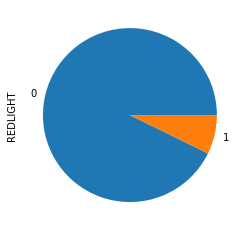

In [56]:
df_KSI_clean5.loc[df_KSI_clean5['ACCLASS']!='Fatal','REDLIGHT'].value_counts().plot.pie()

In [57]:
df_KSI_clean5.dtypes

SPEEDING          int64
AG_DRIV           int64
REDLIGHT          int64
ALCOHOL           int64
DISABILITY        int64
HOUR              int64
ROAD_CLASS_ID     int32
LOCCOORD         object
TRAFFCTL         object
VISIBILITY       object
LIGHT            object
RDSFCOND         object
ACCLASS          object
IMPACTYPE        object
Longitude        object
Latitude         object
IsRedlight        int64
dtype: object

In [58]:
#categorical data
categorical_cols = ['HOUR', 'ROAD_CLASS_ID','LOCCOORD','TRAFFCTL','VISIBILITY','LIGHT','RDSFCOND','IMPACTYPE'] 

#import pandas as pd
df_KSI_clean6 = pd.get_dummies(df_KSI_clean5, columns = categorical_cols)

In [59]:
#create a mapping dictionary, you can just enumerate the categories using a dictionary comprehension
#{col: {n: cat for n, cat in enumerate(df_KSI_clean4[col].astype('category').cat.categories)}
 #    for col in df_KSI_clean4}

#convert the columns to categoricals
#df_KSI_clean5=pd.DataFrame({col: df_KSI_clean4[col].astype('category').cat.codes for col in df_KSI_clean4}, index=df_KSI_clean4.index)


In [60]:
#df_KSI_clean6.info()

In [61]:
# from sklearn.preprocessing import LabelEncoder
#import pandas
#from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()

#df_KSI_clean5['ACCLASS'] = le.fit_transform(df_KSI_clean5['ACCLASS'])
#df_KSI_clean5

## Fixing Class Imbalance

In [62]:
df_KSI_clean6.groupby('ACCLASS').count()['SPEEDING']# / df_KSI_clean4.shape[0]

def encode_acclass(row_val):
    """
    Take in the row value and check the value. 
    Then encode the row based on the value.
    """
    
    if row_val =='Non-Fatal Injury':
        return 0
    else:
        return 1
    
df_KSI_clean6['target']= df_KSI_clean6['ACCLASS'].apply(encode_acclass)

In [63]:
# selecting rows based on Accident Classification
Acclass1_df = df_KSI_clean6[df_KSI_clean6['target'] == 1]
Acclass0_df = df_KSI_clean6[df_KSI_clean6['target'] == 0]

print(Acclass1_df.shape)
print(Acclass0_df.shape)

(684, 94)
(4422, 94)


In [64]:
#
import random 
from random import sample

Acclass0_df=Acclass0_df.sample(2000)
Acclass1_df=Acclass1_df.sample(1000, replace=True)

print(Acclass1_df.shape)
print(Acclass0_df.shape)

(1000, 94)
(2000, 94)


In [65]:
df_KSI_clean7=pd.concat([Acclass0_df, Acclass1_df])
df_KSI_clean7.shape

(3000, 94)

## Random Forest

In [66]:
def generate_model_report (y_actual, predictions):
    print("Accuracy =" , accuracy_score(y_actual, predictions))
    print("Precision =" , precision_score(y_actual, predictions))
    print("Recall =" , recall_score(y_actual, predictions))
    print("F1 Score =" , f1_score(y_actual, predictions))
    pass


In [67]:
#Split the data into Training & Testing

KSI_df=df_KSI_clean7.copy()

# Create our features
X = KSI_df.drop(["ACCLASS", "target"], axis=1)

# Create our target
y=KSI_df["target"].values

print(y)


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y)
X_train.shape

[0 0 0 ... 1 1 1]


(2250, 92)

In [68]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
balanced = BalancedRandomForestClassifier(n_estimators = 500, random_state=1)
balanced.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=500, random_state=1)

In [69]:
# Calculated the balanced accuracy score
y_pred = balanced.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.758

In [70]:
generate_model_report(y_test, y_pred)

Accuracy = 0.7653333333333333
Precision = 0.6258503401360545
Recall = 0.736
F1 Score = 0.6764705882352942


In [71]:
# List the features sorted in descending order by feature importance
dict(sorted(zip(X.columns,balanced.feature_importances_), reverse=True,key = lambda record:record[1]))

{'Latitude': 0.16529666152014436,
 'Longitude': 0.15792949863333747,
 'IMPACTYPE_Pedestrian Collisions': 0.03022821870142906,
 'AG_DRIV': 0.027345138973052966,
 'SPEEDING': 0.02039791113716458,
 'ROAD_CLASS_ID_1': 0.017996449529256577,
 'LIGHT_Daylight': 0.017923061598887298,
 'TRAFFCTL_No Control': 0.01780326555496639,
 'LIGHT_Dark': 0.017006592332594522,
 'IMPACTYPE_Cyclist Collisions': 0.016805457173164656,
 'TRAFFCTL_Traffic Signal': 0.016403187172554613,
 'ROAD_CLASS_ID_3': 0.0158159781531175,
 'IMPACTYPE_Rear End': 0.01486951392020448,
 'LIGHT_Dark, artificial': 0.014786759559763692,
 'LOCCOORD_Intersection': 0.014274799640071601,
 'RDSFCOND_Dry': 0.01394983699972186,
 'LOCCOORD_Mid-Block': 0.013889191785949965,
 'RDSFCOND_Wet': 0.013370684384326542,
 'HOUR_18': 0.01313968603968595,
 'HOUR_15': 0.012816862587605978,
 'HOUR_14': 0.012669143792423997,
 'IMPACTYPE_Turning Movement': 0.012262200629638589,
 'HOUR_17': 0.011990089896893702,
 'HOUR_16': 0.011898828147496812,
 'HOUR_9': 

In [72]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[390, 110],
       [ 66, 184]], dtype=int64)

In [73]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.78      0.74      0.82      0.76      0.58       500
          1       0.63      0.74      0.78      0.68      0.76      0.57       250

avg / total       0.78      0.77      0.75      0.77      0.76      0.57       750



## gradient boosted tree

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier object
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.50]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=500,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test,
            y_test)))
    print()

Learning rate:  0.01
Accuracy score (training): 0.688
Accuracy score (validation): 0.676

Learning rate:  0.05
Accuracy score (training): 0.776
Accuracy score (validation): 0.713

Learning rate:  0.1
Accuracy score (training): 0.824
Accuracy score (validation): 0.724

Learning rate:  0.15
Accuracy score (training): 0.852
Accuracy score (validation): 0.720

Learning rate:  0.2
Accuracy score (training): 0.874
Accuracy score (validation): 0.732

Learning rate:  0.25
Accuracy score (training): 0.893
Accuracy score (validation): 0.735

Learning rate:  0.3
Accuracy score (training): 0.908
Accuracy score (validation): 0.748

Learning rate:  0.5
Accuracy score (training): 0.934
Accuracy score (validation): 0.751



In [75]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=3000,
                                        learning_rate=0.3,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train, y_train)

# Make Prediction
predictions = classifier.predict(X_test)
outcome_df=pd.DataFrame({"Prediction": predictions, "Actual": y_test})
outcome_df

,Prediction,Actual
0,0,0
1,1,1
2,1,1
3,0,1
4,1,1
...,...,...
745,0,0
746,0,0
747,0,0
748,0,0


In [76]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.7946666666666666


In [77]:
generate_model_report(y_test, y_pred)

Accuracy = 0.7653333333333333
Precision = 0.6258503401360545
Recall = 0.736
F1 Score = 0.6764705882352942


In [78]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,419,81
Actual 1,73,177


In [79]:
# Display the confusion matrix
confusion_matrix(y_test, predictions)

array([[419,  81],
       [ 73, 177]], dtype=int64)

In [80]:
# Generate classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       500
           1       0.69      0.71      0.70       250

    accuracy                           0.79       750
   macro avg       0.77      0.77      0.77       750
weighted avg       0.80      0.79      0.80       750



## Unused code

In [81]:
# #from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# #'VEHTYPE','MANOEUVER','DRIVACT','DRIVCOND','LOCCOORD','TRAFFCTL','VISIBILITY','LIGHT','RDSFCOND','ACCLASS','IMPACTYPE']

# df_KSI_clean4 = df_KSI_clean3.copy()
# df_KSI_clean4['VEHTYPE_ENC'] = le.fit_transform(df_KSI_clean4['VEHTYPE'])
# df_KSI_clean4['MANOEUVER_ENC'] = le.fit_transform(df_KSI_clean4['MANOEUVER'])
# df_KSI_clean4['DRIVACT_ENC'] = le.fit_transform(df_KSI_clean4['DRIVACT'])
# df_KSI_clean4['DRIVCOND_ENC'] = le.fit_transform(df_KSI_clean4['DRIVCOND'])
# df_KSI_clean4['LOCCOORD_ENC'] = le.fit_transform(df_KSI_clean4['LOCCOORD'])
# df_KSI_clean4['TRAFFCTL_ENC'] = le.fit_transform(df_KSI_clean4['TRAFFCTL'])
# df_KSI_clean4['VISIBILITY_ENC'] = le.fit_transform(df_KSI_clean4['VISIBILITY'])
# df_KSI_clean4['LIGHT'] = le.fit_transform(df_KSI_clean4['LIGHT'])
# df_KSI_clean4['RDSFCOND'] = le.fit_transform(df_KSI_clean4['RDSFCOND'])
# df_KSI_clean4['ACCLASS'] = le.fit_transform(df_KSI_clean4['ACCLASS'])
# df_KSI_clean4['IMPACTYPE'] = le.fit_transform(df_KSI_clean4['IMPACTYPE'])
# df_KSI_clean4.head()

In [82]:
#Load Road class Table
df_RC_DB=pd.read_csv("../DB_Extracts/road_class.csv")
df_RC_DB.head(10)

,ROAD_CLASS_ID,ROAD_CLASS
0,1,Major Arterial
1,2,Collector
2,3,Minor Arterial
3,4,Local
4,5,Other
5,6,Pending
6,7,Laneway
7,8,Expressway
8,9,Expressway Ramp
9,10,Major Arterial Ramp


In [83]:
#Load Injury table
df_Injury_DB=pd.read_csv("../DB_Extracts/injury.csv")
df_Injury_DB.head(5)

,INJURY_ID,INJURY
0,1,None
1,2,Fatal
2,3,Minor
3,4,Major
4,5,Minimal
